# Finetune EfficientNet-B5


## efficientnetb5_1080repetitive_4


With 1920x1080 repetitive-padded melspectrogram images without data augmentation

Instead of unfreezing just 3, 4 or 5 layers, we unfreeze 6 layers


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnetb5_1080repetitive_4'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b5(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 6 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-6, -5, -4, -3, -2, -1]:  # Use negative indices to target the last 6 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 456x456, suitable for EfficientNet-B5
    transforms.Resize((456, 456)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_25928\2770681902.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=16,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=16,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=16,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.80it/s, Loss=0.43152379989624023, Elapsed=66.2227s, ETA=0.0000s] 


Epoch 1 completed in 730.0101s
Train Loss: 1.0089029130645841 - Train Accuracy: 59.53732389588657
Validation Loss: 0.7792593929005714 - Validation Accuracy: 69.8184888138455

Epoch 2/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.92it/s, Loss=0.8489581346511841, Elapsed=65.3636s, ETA=0.0000s]  


Epoch 2 completed in 729.1973s
Train Loss: 0.7591654386441459 - Train Accuracy: 69.42629067637547
Validation Loss: 0.6662700516980575 - Validation Accuracy: 72.42507387083158

Epoch 3/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.92it/s, Loss=0.05510987713932991, Elapsed=65.3621s, ETA=0.0000s]  


Epoch 3 completed in 728.8463s
Train Loss: 0.6473418473253935 - Train Accuracy: 73.71836910065353
Validation Loss: 0.6125746322308885 - Validation Accuracy: 73.45926551287462

Epoch 4/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.90it/s, Loss=0.1145927906036377, Elapsed=65.3696s, ETA=0.0000s]   


Epoch 4 completed in 728.7767s
Train Loss: 0.570531996630143 - Train Accuracy: 77.39987788607223
Validation Loss: 0.6806337305330507 - Validation Accuracy: 79.80160405234275

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.89it/s, Loss=0.2671872079372406, Elapsed=65.5041s, ETA=0.0000s]   


Epoch 5 completed in 728.9700s
Train Loss: 0.5019137816996935 - Train Accuracy: 79.9868840596097
Validation Loss: 0.583171430240192 - Validation Accuracy: 77.1317011397214

Epoch 6/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.90it/s, Loss=0.9535075426101685, Elapsed=65.5056s, ETA=0.0000s]   


Epoch 6 completed in 729.1183s
Train Loss: 0.4393593338363657 - Train Accuracy: 82.41107166278465
Validation Loss: 0.6478466532251234 - Validation Accuracy: 79.70662726888983

EarlyStopping counter: 1/5
Epoch 7/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.91it/s, Loss=0.021384991705417633, Elapsed=65.4916s, ETA=0.0000s] 


Epoch 7 completed in 728.8631s
Train Loss: 0.3851362163586442 - Train Accuracy: 84.13423486578775
Validation Loss: 0.5985522851517541 - Validation Accuracy: 80.14985225833685

EarlyStopping counter: 2/5
Epoch 8/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.89it/s, Loss=0.4525972306728363, Elapsed=65.6017s, ETA=0.0000s]   


Epoch 8 completed in 729.1163s
Train Loss: 0.337971043491139 - Train Accuracy: 85.97951199656272
Validation Loss: 0.6554175746009935 - Validation Accuracy: 80.42422963275644

EarlyStopping counter: 3/5
Epoch 9/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.90it/s, Loss=0.05450873076915741, Elapsed=65.6187s, ETA=0.0000s]  


Epoch 9 completed in 729.3631s
Train Loss: 0.30544900517449436 - Train Accuracy: 87.03783270391895
Validation Loss: 0.7269612202306183 - Validation Accuracy: 79.17897847192909

EarlyStopping counter: 4/5
Epoch 10/50


Validating: 100%|██████████| 593/593 [00:54<00:00, 10.91it/s, Loss=0.2717513144016266, Elapsed=65.6311s, ETA=0.0000s]   

Epoch 10 completed in 729.3728s
Train Loss: 0.26387282418034563 - Train Accuracy: 88.5145066823455
Validation Loss: 0.7905649773935155 - Validation Accuracy: 80.71971295905446

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


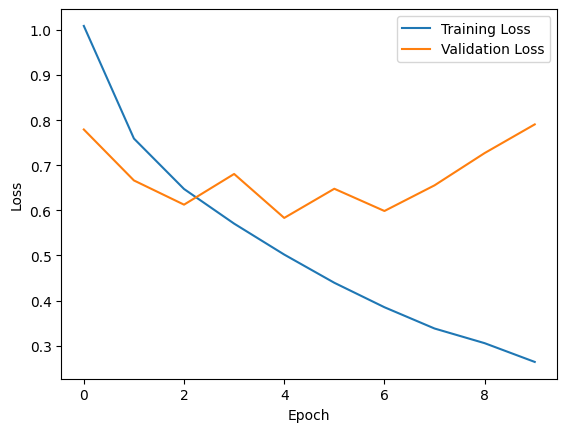

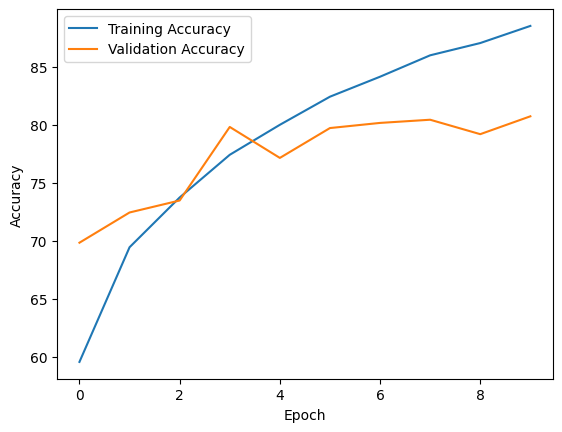

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 593/593 [01:05<00:00,  9.03it/s]

Test Accuracy: 0.7993
Test Precision: 0.8090
Test Recall: 0.7993
Test F1-score: 0.8012

              precision    recall  f1-score   support

       Anger       0.73      0.86      0.79       916
       Bored       0.93      0.83      0.88      1098
     Disgust       0.64      0.60      0.62       291
        Fear       0.52      0.64      0.58       308
       Happy       0.84      0.74      0.79      1914
     Neutral       0.73      0.83      0.78      2226
    Question       0.96      0.89      0.93      1139
         Sad       0.85      0.74      0.79       857
    Surprise       0.79      0.80      0.79       728

    accuracy                           0.80      9477
   macro avg       0.78      0.77      0.77      9477
weighted avg       0.81      0.80      0.80      9477



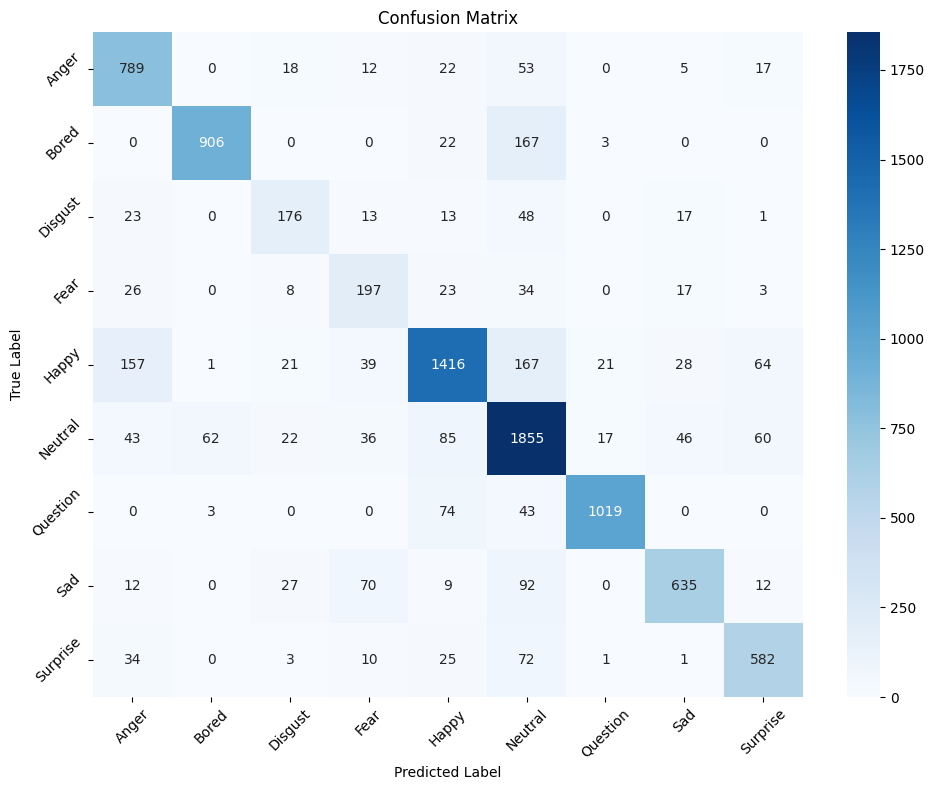

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)